In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from rapidfuzz import process, fuzz
import re
import numpy as np
from typing import Sequence, Mapping, Optional
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import category_encoders as ce

#wrapper methods and embedded methods 
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFECV, RFE

# Cross validation
from sklearn.model_selection import KFold, cross_val_score

# Linear regression models
from sklearn.ensemble import RandomForestRegressor

#Evaluation metrics
from sklearn.metrics import mean_squared_error



In [2]:
"""
    Loads a CSV datasets into pandas DataFrames.
    Handles missing file paths and encoding issues gracefully.
"""
try:
    train_car_data_original = pd.read_csv('data/train.csv')
    test_car_data_original = pd.read_csv('data/test.csv')
    sample_submission_car_data_original = pd.read_csv('data/sample_submission.csv')
# For when the file directory is not found
except FileNotFoundError as f:
    print(f"File not found: {f.filename}")
# For general errors
except Exception as e:
    print(f"An error occurred: {e}")

# Makes a preventive copy so it does not modify the original reference
train_car_data = train_car_data_original.copy()
test_car_data = test_car_data_original.copy()
sample_submission_car_data = sample_submission_car_data_original.copy()



In [3]:
# chech to see if the train and test datasets were correctly imported
print("Train dataset:")
print(train_car_data.shape)

print("Test dataset:")
print(test_car_data.shape)

print("Samples submission dataset:")
print(sample_submission_car_data.shape)

Train dataset:
(75973, 14)
Test dataset:
(32567, 13)
Samples submission dataset:
(32567, 2)


In [4]:
train_car_data["train"] = True
test_car_data["train"] = False

In [5]:
df = pd.concat([train_car_data, test_car_data], ignore_index=True)

In [6]:
df

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,train
0,69512,VW,Golf,2016.0,22290.0,Semi-Auto,28421.00000,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0,True
1,53000,Toyota,Yaris,2019.0,13790.0,Manual,4589.00000,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0,True
2,6366,Audi,Q2,2019.0,24990.0,Semi-Auto,3624.00000,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0,True
3,29021,Ford,FIESTA,2018.0,12500.0,anual,9102.00000,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0,True
4,10062,BMW,2 Series,2019.0,22995.0,Manual,1000.00000,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108535,105775,VW,Tiguan,2017.0,NaN,Manual,27575.00000,Petrol,145.0,46.300000,1.4,94.0,1.000000,0.0,False
108536,81363,BMW,X2,2020.0,NaN,Automatic,1980.00000,Petrol,145.0,34.000000,2.0,39.0,3.000000,0.0,False
108537,76833,Audi,Q5,2019.0,NaN,Semi-Auto,8297.00000,Diesel,145.0,38.200000,2.0,88.0,4.000000,0.0,False
108538,91768,Mercedes,A Class,2019.0,NaN,Manual,-50755.21023,Petrol,145.0,28.500000,1.3,81.0,1.000000,0.0,False


In [7]:
df = df.set_index("carID")

In [8]:
unique_values = df.apply(lambda x: x.unique()).to_dict()

for col, values in unique_values.items():
    print(f"{col}:\n{values}\n")

Brand:
['VW' 'Toyota' 'Audi' 'Ford' 'BMW' 'Skoda' 'Opel' 'Mercedes' 'FOR'
 'mercedes' 'Hyundai' 'w' 'ord' 'MW' 'bmw' nan 'yundai' 'BM' 'Toyot' 'udi'
 'Ope' 'AUDI' 'V' 'opel' 'pel' 'For' 'pe' 'Mercede' 'audi' 'MERCEDES'
 'OPEL' 'koda' 'FORD' 'Hyunda' 'W' 'Aud' 'vw' 'hyundai' 'skoda' 'ford'
 'TOYOTA' 'ercedes' 'oyota' 'toyota' 'SKODA' 'Skod' 'HYUNDAI' 'kod' 'v'
 'for' 'SKOD' 'aud' 'KODA' 'PEL' 'yunda' 'or' 'UDI' 'OYOTA' 'HYUNDA' 'mw'
 'OPE' 'mercede' 'ERCEDES' 'ercede' 'TOYOT' 'MERCEDE' 'ORD' 'ud' 'ope'
 'AUD' 'hyunda' 'skod' 'toyot' 'M' 'YUNDAI' 'oyot' 'bm']

model:
[' Golf' ' Yaris' ' Q2' ' FIESTA' ' 2 Series' '3 Series' ' A3' ' Octavia'
 ' Passat' ' Focus' ' Insignia' ' A Clas' ' Q3' ' Fabia' ' A Class' ' Ka+'
 ' 3 Series' ' GLC Class' ' I30' ' C Class' ' Polo' ' E Class' ' C Clas'
 ' Q5' ' Up' ' Fiesta' ' C-HR' ' Mokka X' ' Corsa' ' Astra' ' TT'
 ' 5 Series' ' Aygo' ' 4 Series' ' SLK' ' Viva' ' T-Roc' 'Focus'
 ' EcoSport' ' Tucson' ' EcoSpor' nan ' X-CLASS' ' CL Class' ' IX20'
 ' i20

### Format dTypes

In [9]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Brand,106370,76,Ford,21168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,106373,800,Focus,9074,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,106396.0,NaN,NaN,NaN,2017.098317,2.208475,1970.0,2016.0,2017.0,2019.0,2024.121759
price,75973.0,NaN,NaN,NaN,16881.889553,9736.926322,450.0,10200.0,14699.0,20950.0,159999.0
transmission,106395,40,Manual,54362,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mileage,106388.0,NaN,NaN,NaN,22988.745136,22130.587005,-58540.574478,7384.75,17279.5,32450.25,323000.0
fuelType,106373,35,Petrol,54108,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tax,97328.0,NaN,NaN,NaN,120.401276,65.532777,-91.12163,125.0,145.0,145.0,580.0
mpg,97326.0,NaN,NaN,NaN,55.170133,16.850973,-43.421768,46.3,54.3,62.8,470.8
engineSize,106396.0,NaN,NaN,NaN,1.661709,0.573766,-0.103493,1.2,1.6,2.0,6.6


In [10]:
# has Damage column is completely reduandant as it has the same value for all observation. Dosent add anything.

df.drop(labels=["hasDamage"], inplace=True, axis=1)

In [11]:
# Enforce int values for cols previousOwners, year. The values will be rouded to avoid incorrect or overestimarion of some values
df[["year", "previousOwners"]] = df[["year", "previousOwners"]].apply(np.floor).astype("int", errors="ignore")

In [12]:
len(df)

108540

In [13]:
cols = ["mpg", "mileage", "engineSize", "previousOwners"]

(df[cols] < 0).sum()

mpg                53
mileage           539
engineSize        117
previousOwners    539
dtype: int64

In [14]:
df[cols] = df[cols].where(df[cols] >= 0, np.nan)

In [15]:
df.isna().sum()

Brand              2170
model              2167
year               2144
price             32567
transmission       2145
mileage            2691
fuelType           2167
tax               11212
mpg               11267
engineSize         2261
paintQuality%      2149
previousOwners     2686
train                 0
dtype: int64

In [16]:
len(df)

108540

### Fuzzy Matching - Solução Diogo 

In [17]:
col_c = df.columns[(df.dtypes == "object") | (df.nunique() < 20)].tolist()
col_n = df.columns.difference(col_c).tolist()

In [18]:
col_c

['Brand', 'model', 'transmission', 'fuelType', 'previousOwners', 'train']

In [19]:
col_n

['engineSize', 'mileage', 'mpg', 'paintQuality%', 'price', 'tax', 'year']

In [20]:
# First of all we will lowercase these 4 cols to ensure data consistency when comparing strings
cols_fuzzy = ["Brand", "model", "transmission", "fuelType"]

In [21]:
unique_values = df[cols_fuzzy].apply(lambda x: x.unique()).to_dict()

for col, values in unique_values.items():
    print(f"{col}:\n{values}\n")

Brand:
['VW' 'Toyota' 'Audi' 'Ford' 'BMW' 'Skoda' 'Opel' 'Mercedes' 'FOR'
 'mercedes' 'Hyundai' 'w' 'ord' 'MW' 'bmw' nan 'yundai' 'BM' 'Toyot' 'udi'
 'Ope' 'AUDI' 'V' 'opel' 'pel' 'For' 'pe' 'Mercede' 'audi' 'MERCEDES'
 'OPEL' 'koda' 'FORD' 'Hyunda' 'W' 'Aud' 'vw' 'hyundai' 'skoda' 'ford'
 'TOYOTA' 'ercedes' 'oyota' 'toyota' 'SKODA' 'Skod' 'HYUNDAI' 'kod' 'v'
 'for' 'SKOD' 'aud' 'KODA' 'PEL' 'yunda' 'or' 'UDI' 'OYOTA' 'HYUNDA' 'mw'
 'OPE' 'mercede' 'ERCEDES' 'ercede' 'TOYOT' 'MERCEDE' 'ORD' 'ud' 'ope'
 'AUD' 'hyunda' 'skod' 'toyot' 'M' 'YUNDAI' 'oyot' 'bm']

model:
[' Golf' ' Yaris' ' Q2' ' FIESTA' ' 2 Series' '3 Series' ' A3' ' Octavia'
 ' Passat' ' Focus' ' Insignia' ' A Clas' ' Q3' ' Fabia' ' A Class' ' Ka+'
 ' 3 Series' ' GLC Class' ' I30' ' C Class' ' Polo' ' E Class' ' C Clas'
 ' Q5' ' Up' ' Fiesta' ' C-HR' ' Mokka X' ' Corsa' ' Astra' ' TT'
 ' 5 Series' ' Aygo' ' 4 Series' ' SLK' ' Viva' ' T-Roc' 'Focus'
 ' EcoSport' ' Tucson' ' EcoSpor' nan ' X-CLASS' ' CL Class' ' IX20'
 ' i20

In [22]:
def normalize_string(string: str) -> str:
    string = str(string).lower().strip()
    return re.sub(r"[^a-z0-9]+", "", string) # removes spaces


def fuzzy_fix(x: object, correct_names: Sequence[str], aliases: Optional[Mapping[str, str]] = None,  cutoff: int = 80):

    # creates a dict with the normalized strings as the keys and the not normalized strings as values from the input list
    canon_map = {normalize_string(label): label for label in correct_names}
    # create a list with only the keys (normalized strings)
    choice_keys = list(canon_map.keys())

    normalized_name = normalize_string(x)

    # Normalize alias keys too; alias values should be canonical brands
    if aliases:
        alias_normalized = {normalize_string(key): value for key, value in aliases.items()}
        if normalized_name in alias_normalized:
            return alias_normalized[normalized_name]

    # if the normalized string is already the correct name return it
    if normalized_name in canon_map:
        return canon_map[normalized_name]

    # it the normalized string doesn't correct to the correct name the use fuzzy match to match the name to the correct one
    match = process.extractOne(normalized_name, choice_keys, scorer=fuzz.WRatio, score_cutoff=cutoff)
    return canon_map[match[0]] if match else np.nan # returns the match with the highest similarity score

In [23]:
brands_list = ["Volkswagen", "Toyota", "Audi", "Ford", "BMW", "Skoda", "Opel", "Mercedes", "Hyundai"]
brands_aliases = {"vw":"Volkswagen","v":"Volkswagen","merc":"Mercedes","bm":"BMW"}

In [24]:
train_fuzzy = df[df["train"] == True][cols_fuzzy]

train_fuzzy["Brand"] = train_fuzzy["Brand"].map(lambda brand: fuzzy_fix(brand, brands_list, brands_aliases, cutoff=84))
train_fuzzy["Brand"].unique()

array(['Volkswagen', 'Toyota', 'Audi', 'Ford', 'BMW', 'Skoda', 'Opel',
       'Mercedes', 'Hyundai', nan], dtype=object)

In [25]:
test_fuzzy = df[df["train"] == False][cols_fuzzy]

test_fuzzy["Brand"] = test_fuzzy["Brand"].map(lambda brand: fuzzy_fix(brand, brands_list, brands_aliases, cutoff=84))
test_fuzzy["Brand"].unique()

array(['Hyundai', 'Volkswagen', 'BMW', 'Opel', 'Ford', 'Mercedes',
       'Skoda', 'Toyota', 'Audi', nan], dtype=object)

In [26]:
transmissions_list = ["Manual","Automatic","Semi-Automatic", "Other", "Unkown"]
transmissions_alises = {"mt":"Manual","man":"Manual","auto":"Automatic","at":"Automatic","dsg":"Automatic"}

In [27]:
train_fuzzy["transmission"] = train_fuzzy["transmission"].map(lambda transmission: fuzzy_fix(transmission, transmissions_list, transmissions_alises, cutoff=82))
train_fuzzy["transmission"].unique()

array(['Semi-Automatic', 'Manual', 'Automatic', nan, 'Unkown', 'Other'],
      dtype=object)

In [28]:
test_fuzzy["transmission"] = test_fuzzy["transmission"].map(lambda transmission: fuzzy_fix(transmission, transmissions_list, transmissions_alises, cutoff=82))
test_fuzzy["transmission"].unique()

array(['Automatic', 'Semi-Automatic', 'Manual', 'Unkown', nan, 'Other'],
      dtype=object)

In [29]:
fueltype_list = ["Petrol", "Diesel", "Hybrid", "Electric", "Other"]

In [30]:
train_fuzzy["fuelType"] = train_fuzzy["fuelType"].map(lambda fueltype: fuzzy_fix(fueltype, fueltype_list, cutoff=82))
train_fuzzy["fuelType"].unique()

array(['Petrol', 'Diesel', 'Hybrid', nan, 'Other', 'Electric'],
      dtype=object)

In [31]:
test_fuzzy["fuelType"] = test_fuzzy["fuelType"].map(lambda fueltype: fuzzy_fix(fueltype, fueltype_list, cutoff=82))
test_fuzzy["fuelType"].unique()

array(['Petrol', 'Diesel', 'Hybrid', nan, 'Other', 'Electric'],
      dtype=object)

In [32]:
# Do the same for the car models columns
MODEL_BY_BRAND = {
    'Audi': ['A', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'Q', 'Q2', 'Q3', 'Q5', 'Q7', 'Q8', 'RS', 'RS3', 'RS4', 'RS5', 'RS6', 'S', 'S1', 'S3', 'S4', 'S5', 'S6', 'SQ2', 'SQ5', 'TT', 'e-tron'],
    'BMW': ['1 Series', '2 Series', '3 Serie', '3 SERIES', '3 Series', '4 Series', '5 Serie', '5 Series', '7 Series', '8 Series', 'M2', 'M3', 'M4', 'M5', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'Z4', 'i3', 'i4'],
    'Ford': ['B-MAX', 'C-MAX', 'Ecosport', 'Edge', 'Fiesta', 'Focus', 'Galaxy', 'Ka', 'Kuga', 'Mondeo', 'Mustang', 'Puma', 'S-MAX', 'Tourneo', 'Transit'],
    'Hyundai': ['Accent', 'Getz', 'I1', 'I10', 'I2', 'I20', 'I3', 'I30', 'I40', 'I80', 'I800', 'IONIQ', 'Kona', 'Santa Fe', 'Tucson'],
    'Mercedes': ['A-Class', 'AMG GT', 'B-Class', 'C-Class', 'CLA', 'CLK', 'CLS', 'Citan', 'E-Class', 'GLA', 'GLB', 'GLC', 'GLE', 'GLK', 'GLS', 'M-Class', 'S-Class', 'GLC-Class', 'SL', 'SLC', 'SLK', 'Sprinter', 'V-Class', 'Vaneo', 'Viano'],
    'Opel': ['Adam', 'Astra', 'Corsa', 'Crossland', 'Grandland', 'Insignia', 'Karl', 'Meriva', 'Mokka', 'Vectra', 'Zafira'],
    'Skoda': ['Citigo', 'Enyaq', 'Fabia', 'Kamiq', 'Karoq', 'Kodiaq', 'Octavia', 'Rapid', 'Roomster', 'Scala', 'Superb', 'Yeti'],
    'Toyota': ['Auris', 'Avensis', 'Aygo', 'C-HR', 'Camry', 'Corolla', 'GT86', 'RAV4', 'Verso', 'Yaris'],
    'Volkswagen': ['Arteon', 'Beetle', 'Bora', 'Caddy', 'CC', 'Crafter', 'Eos', 'Fox', 'Golf', 'Golf Plus', 'ID.3', 'ID.4', 'Jetta', 'Lupo', 'Passat', 'Phaeton', 'Polo', 'Scirocco', 'Sharan', 'T-Cross', 'T-Roc', 'Tiguan', 'Touareg', 'Touran', 'Transporter', 'Up'],
}


def fix_car_models(raw_model_names: str, cleaned_brand_names):

    candidates = MODEL_BY_BRAND.get(cleaned_brand_names)
    
    if not candidates:
        # fallback to all models if brand unknown
        candidates = sorted({m for lst in MODEL_BY_BRAND.values() for m in lst})
    
    # token_set_ratio handles word order/extra tokens well
    return fuzzy_fix(raw_model_names, candidates, aliases=None, cutoff=86)

In [33]:
train_fuzzy["model"] = train_fuzzy.apply(lambda r: fix_car_models(r["model"], r["Brand"]), axis=1)
train_fuzzy["model"].unique()

array(['Golf', 'Yaris', 'Q2', 'Fiesta', '2 Series', '3 Series', 'A3',
       'Octavia', 'Passat', 'Focus', 'Insignia', 'A-Class', 'Q3', 'Fabia',
       'Ka', 'GLC-Class', 'I30', 'C-Class', 'Polo', 'E-Class', nan, 'Q5',
       'Up', 'C-HR', 'Mokka', 'Corsa', 'Astra', 'TT', '5 Series', 'Aygo',
       '4 Series', 'SLK', 'T-Roc', 'Ecosport', 'Tucson', 'CLA', 'I20',
       'Rapid', 'A1', 'Auris', 'Sharan', 'Adam', 'X3', 'A8', 'B-MAX',
       'A4', 'Kona', 'I10', 'S-MAX', 'X2', 'Crossland', 'Tiguan', 'A5',
       'Zafira', 'IONIQ', 'A6', 'Mondeo', 'Yeti', 'X1', 'Scala',
       'S-Class', '1 Series', 'Kamiq', 'Kuga', 'Tourneo', 'Q7', 'Arteon',
       'Santa Fe', 'Grandland', 'I800', 'RAV4', 'Touran', 'Citigo',
       'Roomster', 'Corolla', 'B-Class', 'Q', 'Kodiaq', 'V-Class', 'A',
       'Caddy', 'Superb', 'Getz', 'Beetle', 'Galaxy', 'M3', 'X4',
       '3 Serie', 'M4', 'Z4', 'X5', 'Meriva', 'RS6', 'Verso', 'Touareg',
       'C-MAX', 'Puma', 'I40', 'Karoq', 'I3', 'T-Cross', 'A7',
       'Golf 

In [34]:
test_fuzzy["model"] = test_fuzzy.apply(lambda r: fix_car_models(r["model"], r["Brand"]), axis=1)
test_fuzzy["model"].unique()

array(['I30', 'Tiguan', '2 Series', 'Grandland', '1 Series', 'Fiesta',
       'X1', 'B-Class', 'Focus', 'Superb', '5 Series', 'C-Class', 'Up',
       'Aygo', 'Golf', 'M-Class', nan, 'TT', 'Adam', 'Zafira', 'E-Class',
       '3 Series', 'A4', 'Yaris', 'Passat', 'I10', 'Mokka', 'Ecosport',
       '4 Series', 'A7', 'Corsa', 'Kuga', 'C-MAX', 'Q2', 'M4', 'A-Class',
       'RAV4', 'Fabia', 'Insignia', 'A1', 'X6', 'Meriva', 'Octavia',
       'Auris', 'CLA', 'Astra', 'V-Class', 'Polo', 'Karoq', 'Q5',
       'Tucson', 'A3', 'S-Class', 'Corolla', 'Ka', 'X3', 'I40', 'I20',
       'Kamiq', 'Crossland', 'Q3', 'Galaxy', 'X2', 'Kodiaq', 'GLC-Class',
       'Mondeo', 'Touran', 'X5', 'Verso', 'Touareg', 'T-Roc', 'Q', 'A5',
       'Scirocco', 'X7', 'B-MAX', '8 Series', 'A', 'A6', 'Santa Fe',
       'Beetle', 'X4', 'Sharan', 'Golf Plus', 'A8', 'Kona', 'Citigo',
       'Rapid', '3 Serie', 'SLK', 'Yeti', 'Q7', 'C-HR', 'M5', 'T-Cross',
       'Avensis', 'IONIQ', 'Z4', 'M2', 'M3', 'Arteon', 'Scala', 'Puma',


In [35]:
def findModel(df):
    count = 0
    # get indices where Brand is missing but model is not
    model_noBrand_index = df[df["Brand"].isna() & df["model"].notna()].index

    for index in model_noBrand_index:
        model = df.at[index, "model"]
        keys_found = [brand for brand, lst in MODEL_BY_BRAND.items() if model in lst]

        if keys_found:
            df.at[index, "Brand"] = keys_found[0]
            count += 1

    print(f"A total of {count} models without the respective brand were found and filled.")
    return df

In [36]:
train_fuzzy = findModel(train_fuzzy)

A total of 1515 models without the respective brand were found and filled.


In [37]:
test_fuzzy = findModel(test_fuzzy)

A total of 644 models without the respective brand were found and filled.


In [38]:
df.isna().sum()

Brand              2170
model              2167
year               2144
price             32567
transmission       2145
mileage            2691
fuelType           2167
tax               11212
mpg               11267
engineSize         2261
paintQuality%      2149
previousOwners     2686
train                 0
dtype: int64

In [39]:
df[cols_fuzzy] = pd.concat([train_fuzzy, test_fuzzy])
df

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,train
carID,,,,,,,,,,,,,
69512,Volkswagen,Golf,2016.0,22290.0,Semi-Automatic,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.0,True
53000,Toyota,Yaris,2019.0,13790.0,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.0,True
6366,Audi,Q2,2019.0,24990.0,Semi-Automatic,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.0,True
29021,Ford,Fiesta,2018.0,12500.0,Manual,9102.0,Petrol,145.0,65.700000,1.0,50.0,NaN,True
10062,BMW,2 Series,2019.0,22995.0,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105775,Volkswagen,Tiguan,2017.0,NaN,Manual,27575.0,Petrol,145.0,46.300000,1.4,94.0,1.0,False
81363,BMW,X2,2020.0,NaN,Automatic,1980.0,Petrol,145.0,34.000000,2.0,39.0,3.0,False
76833,Audi,Q5,2019.0,NaN,Semi-Automatic,8297.0,Diesel,145.0,38.200000,2.0,88.0,4.0,False


In [40]:
# if both brand and model nan then drop
index_drop = df[df.Brand.isna() & df.model.isna()].index
df.drop(labels=index_drop, inplace=True)
len(index_drop)

14

# Missing Values

In [41]:
df.isna().sum()

Brand                 0
model              4314
year               2144
price             32562
transmission       2146
mileage            2691
fuelType           2167
tax               11211
mpg               11267
engineSize         2261
paintQuality%      2149
previousOwners     2686
train                 0
dtype: int64

In [42]:
train_df = df[df["train"] == True]

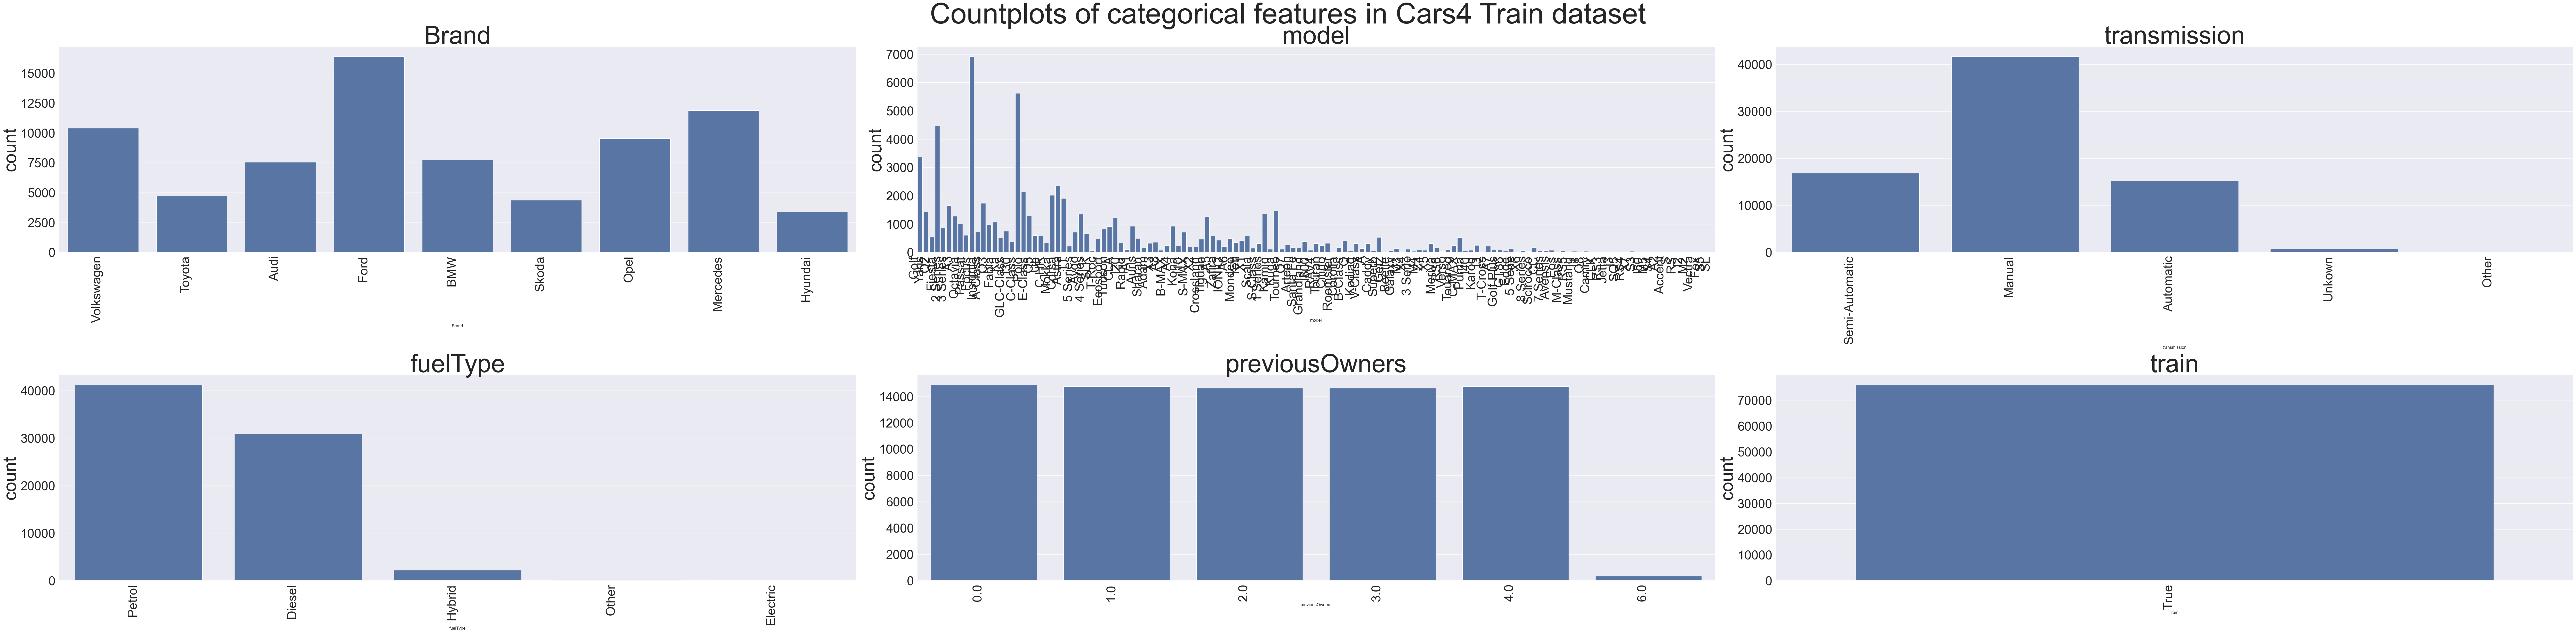

In [43]:
sns.set()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(100, 25), tight_layout=True)

for ax, feature in zip(axes.flatten(), col_c):
    sns.countplot(data=train_df[col_c], x=feature, ax=ax)
    ax.set_title(feature, fontsize=70, pad=8)

    ax.set_ylabel("count", fontsize=50)

    ax.tick_params(axis='both', labelsize=35)

    plt.setp(ax.get_xticklabels(), rotation=90, ha='right')


fig.set_constrained_layout_pads(wspace=0.1, hspace=0.15, w_pad=0.4, h_pad=0.3)
plt.suptitle("Countplots of categorical features in Cars4 Train dataset", fontsize=80)
plt.show()

In [44]:
df.isna().sum()

Brand                 0
model              4314
year               2144
price             32562
transmission       2146
mileage            2691
fuelType           2167
tax               11211
mpg               11267
engineSize         2261
paintQuality%      2149
previousOwners     2686
train                 0
dtype: int64

In [45]:
for col in col_c:
    if  col in ["Brand", "transmission", "model"]:
        df[col].fillna("Unkown", inplace=True)
    if col == "previousOwners":
        train_feature_median = train_df[col].median()
        df[col].fillna(train_feature_median, inplace=True)
    else:
        df[col].fillna("Other", inplace=True)


C:\Users\henri\AppData\Local\Temp\ipykernel_8120\652912495.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("Unkown", inplace=True)
C:\Users\henri\AppData\Local\Temp\ipykernel_8120\652912495.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doi

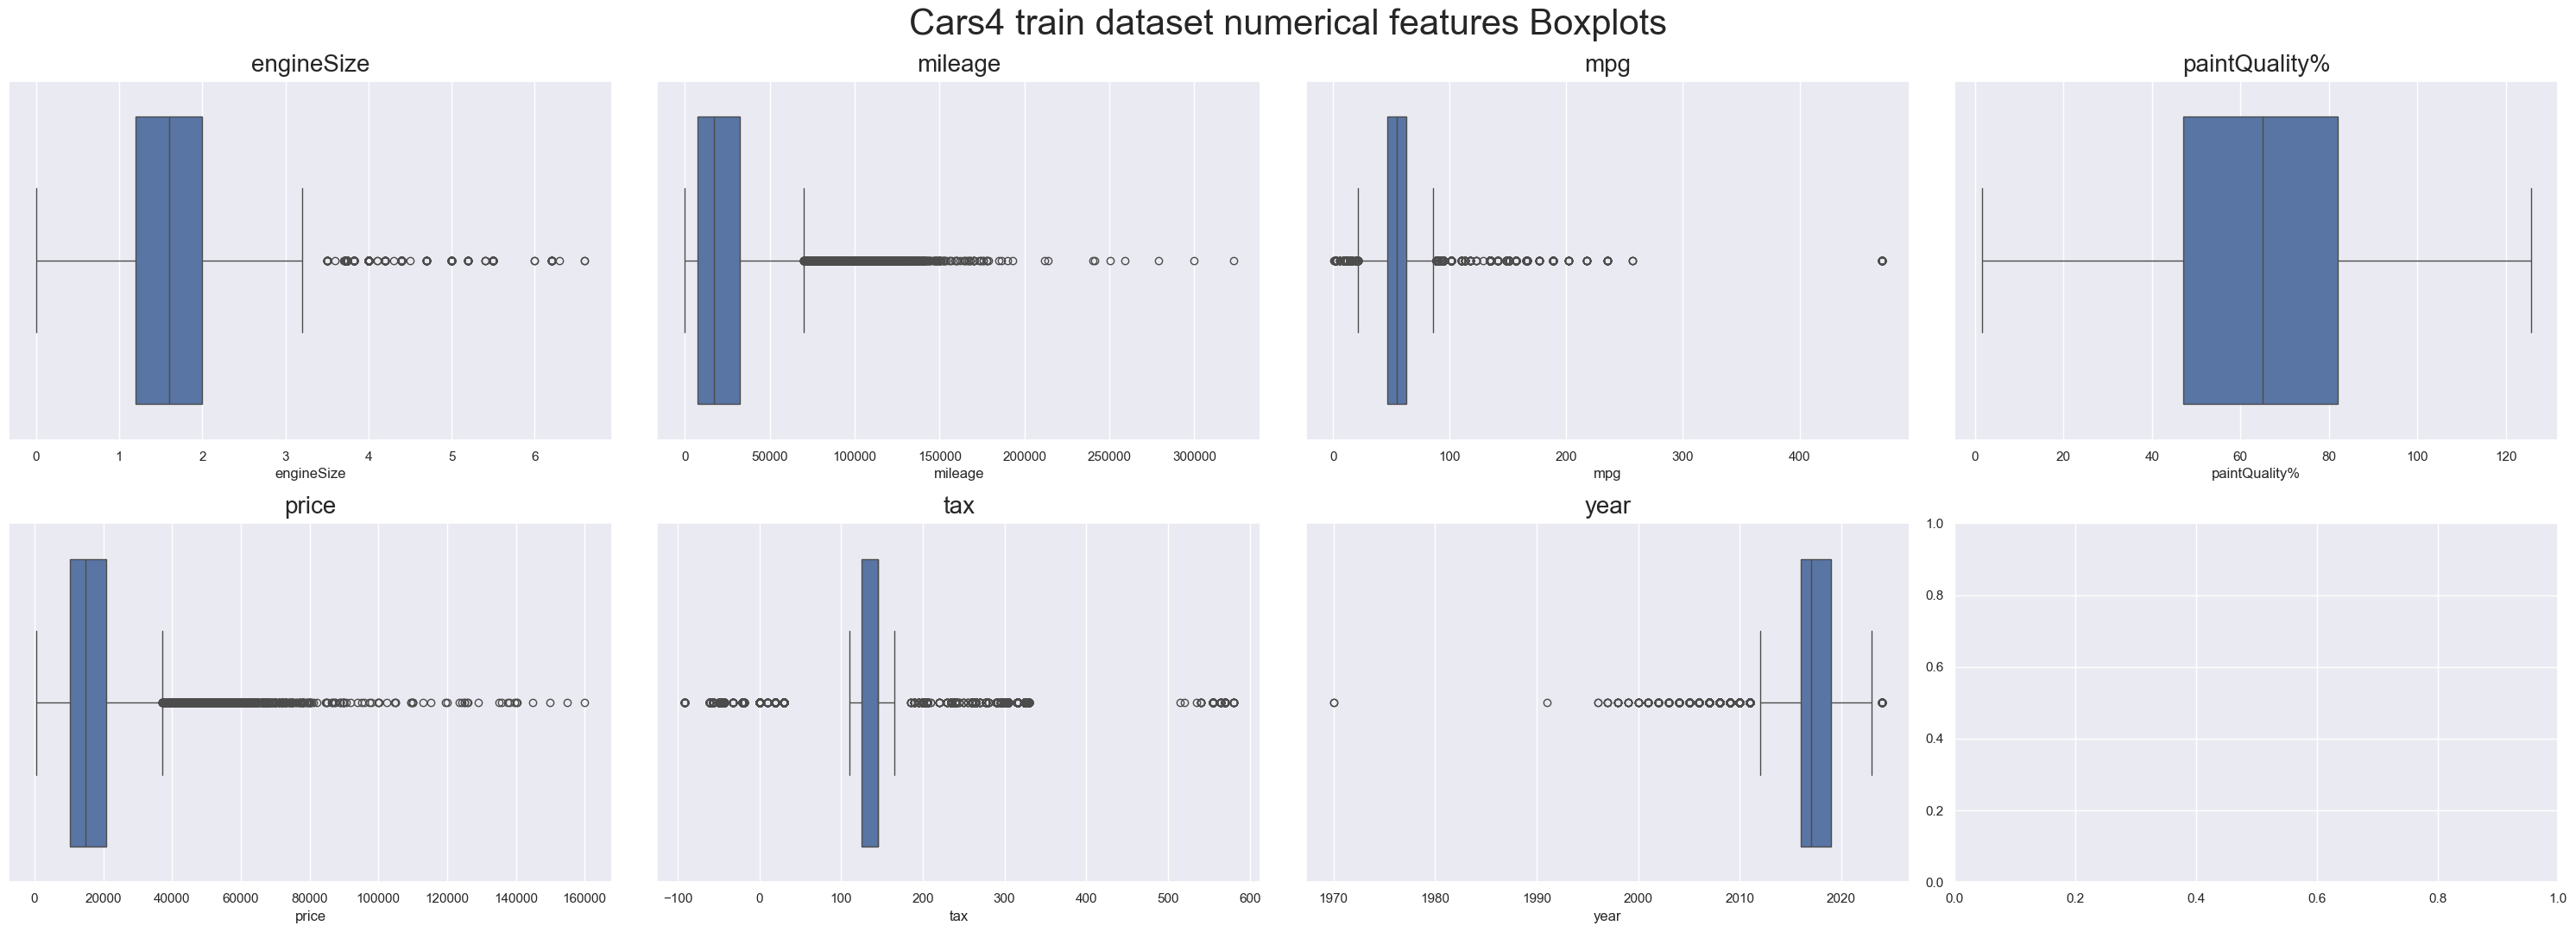

In [46]:


# boxplot train data

sns.set()

# create individual axes for each one of the boxplots 
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 11), tight_layout=True) 

# Iterate over each one of the elements and plot their boxplots
for ax, feature in zip(axes.flatten(), col_n):
    sns.boxplot(x=df[feature], ax=ax)
    ax.set_title(feature, fontsize=20, pad=8)

plt.suptitle("Cars4 train dataset numerical features Boxplots", fontsize=30)    

plt.show()



In [47]:
col_n

['engineSize', 'mileage', 'mpg', 'paintQuality%', 'price', 'tax', 'year']

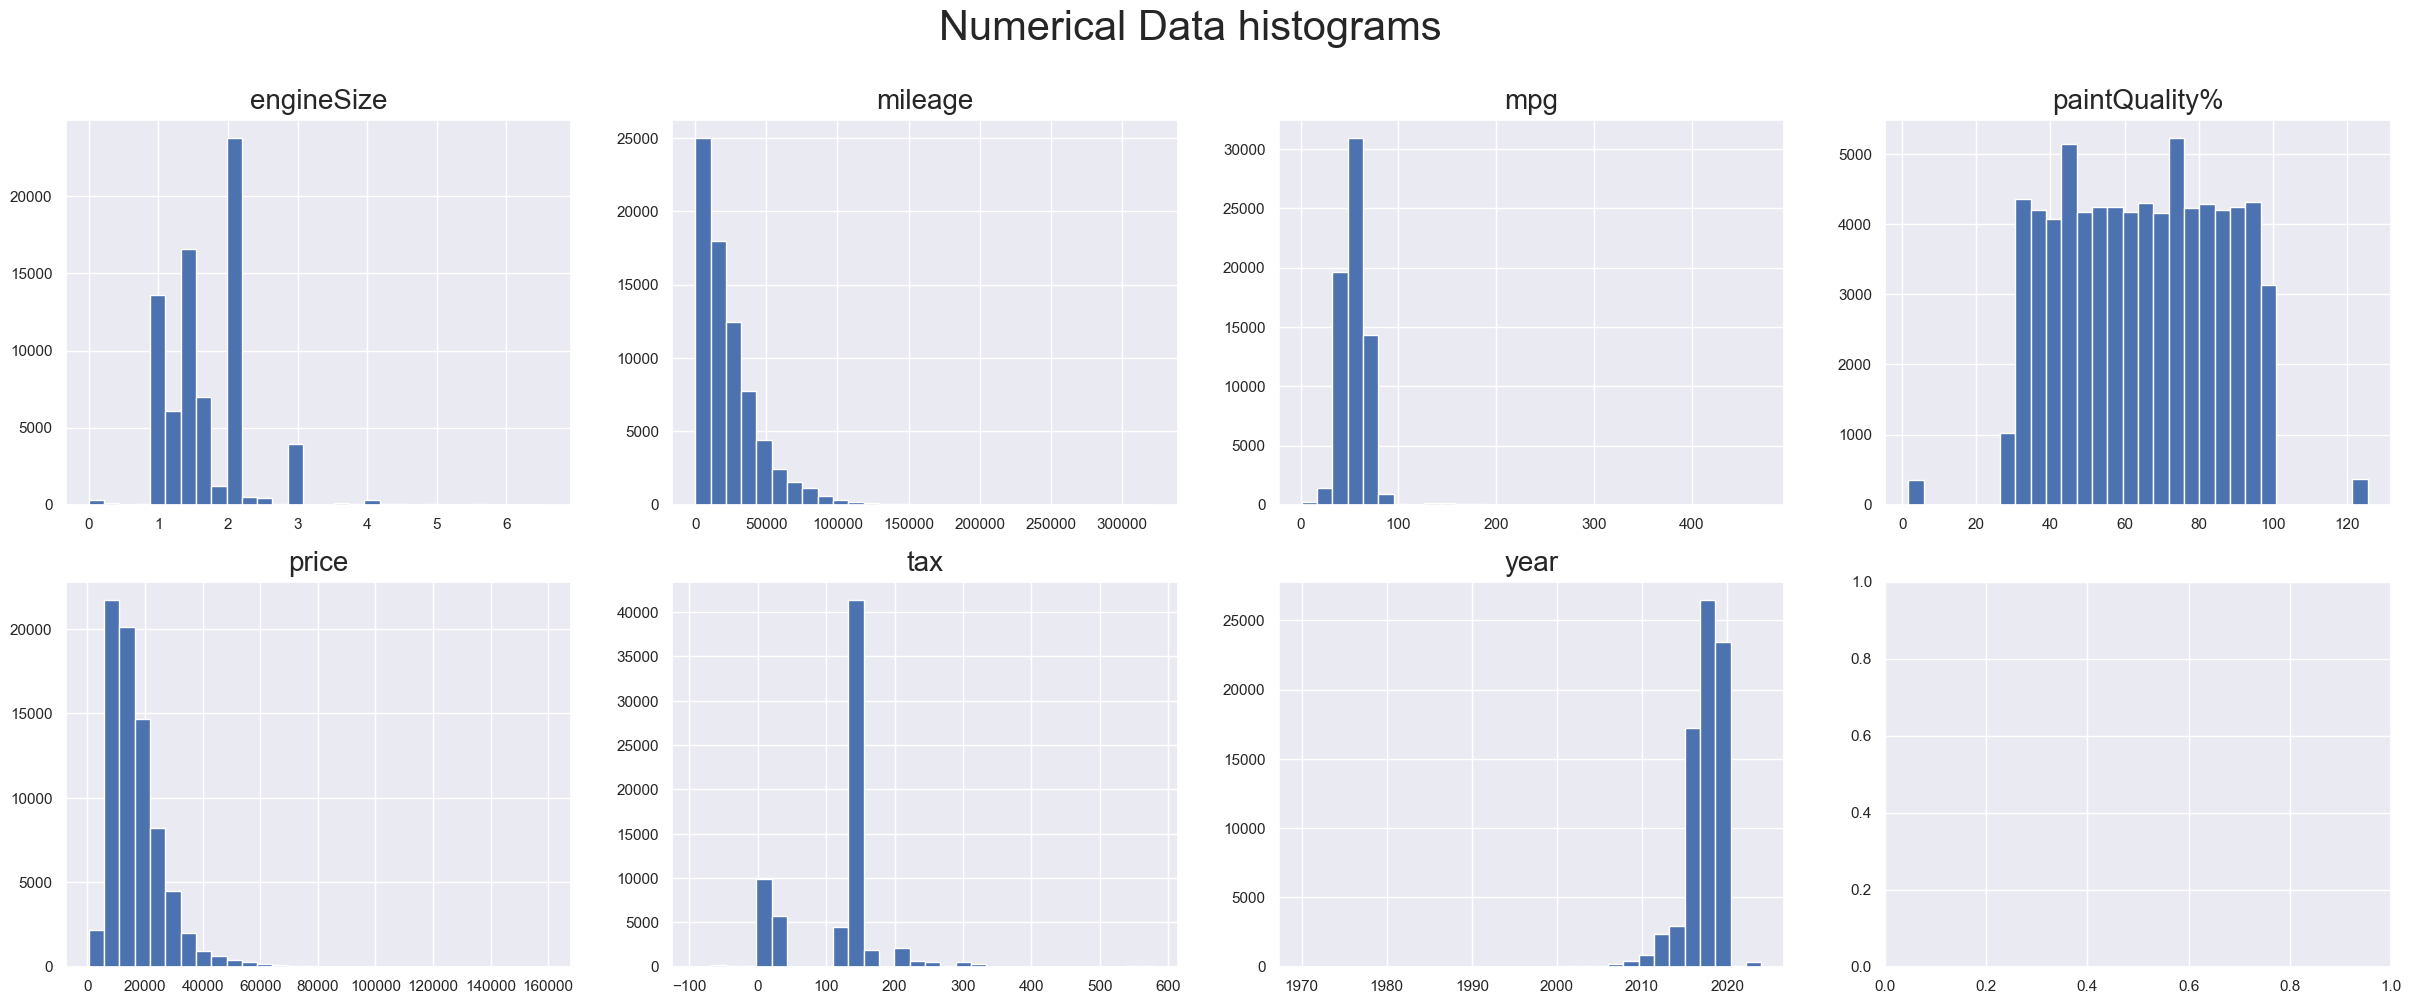

In [48]:


# Plot the numerical data (histograms)
sns.set()

# create individual axes for each one of the histograms 
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 11)) 

# Iterate over each one of the elements and plot their histograms
for ax, feature in zip(axes.flatten(), train_df[col_n]):
    ax.hist(train_df[feature], bins=30)
    ax.set_title(feature, fontsize=20, pad=8)

# flatten turns a 2D array into a 1D array
# zip pairs each axis with one or more other iterables element-by-element
plt.suptitle("Numerical Data histograms", fontsize=30)

plt.show()

In [49]:
for feature in col_n:
    if feature in ["mileage", "tax",  "engineSize"]:
        train_feature_median = train_df[feature].median()
        
        # fill the missing values in train dataset with train median
        df[feature].fillna(train_feature_median, inplace=True)
    
    elif feature in ["mpg", "paintQuality%",  "year"]:
        train_feature_mean = train_df[feature].mean()

        df[feature].fillna(train_feature_mean, inplace=True)

C:\Users\henri\AppData\Local\Temp\ipykernel_8120\1885778135.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[feature].fillna(train_feature_median, inplace=True)
C:\Users\henri\AppData\Local\Temp\ipykernel_8120\1885778135.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

In [50]:
df.isna().sum()

Brand                 0
model                 0
year                  0
price             32562
transmission          0
mileage               0
fuelType              0
tax                   0
mpg                   0
engineSize            0
paintQuality%         0
previousOwners        0
train                 0
dtype: int64

In [51]:

train_cars_mask = (
    (df["train"] == True) 
    &
    (df["price"] <= 80000)
    &
    (df["mileage"].between(0, 150_000))
    &
    (df["tax"].between(0, 300))
    &
    (df["mpg"].between(0, 150))
    &
    (df["engineSize"].between(0, 5))

) 

train_no_outliers = df[train_cars_mask]
test_no_outliers = df[df["train"] == False]

# Combine them back
df_no_outliers = pd.concat([train_no_outliers, test_no_outliers], axis=0)

In [52]:
## Encoding

In [53]:
df_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107259 entries, 69512 to 99627
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Brand           107259 non-null  object 
 1   model           107259 non-null  object 
 2   year            107259 non-null  float64
 3   price           74697 non-null   float64
 4   transmission    107259 non-null  object 
 5   mileage         107259 non-null  float64
 6   fuelType        107259 non-null  object 
 7   tax             107259 non-null  float64
 8   mpg             107259 non-null  float64
 9   engineSize      107259 non-null  float64
 10  paintQuality%   107259 non-null  float64
 11  previousOwners  107259 non-null  float64
 12  train           107259 non-null  bool   
dtypes: bool(1), float64(8), object(4)
memory usage: 10.7+ MB


In [54]:
col_c

['Brand', 'model', 'transmission', 'fuelType', 'previousOwners', 'train']

In [55]:
df_no_outliers["year"]= df_no_outliers["year"].astype("int64")
df_no_outliers["year"].unique()

array([2016, 2019, 2018, 2014, 2017, 2020, 2013, 2015, 2023, 2011, 2012,
       2007, 2005, 2004, 2010, 2024, 2009, 2006, 2000, 2008, 2003, 2022,
       2002, 1996, 1998, 1970, 1999, 2001, 1997, 1991])

In [56]:
pearson_corr = round(df[col_n].corr(), 3)
pearson_corr

,engineSize,mileage,mpg,paintQuality%,price,tax,year
engineSize,1.000,0.101,-0.212,0.003,0.607,0.237,-0.038
mileage,0.101,1.000,0.163,-0.002,-0.412,-0.193,-0.674
mpg,-0.212,0.163,1.000,-0.002,-0.275,-0.401,-0.116
paintQuality%,0.003,-0.002,-0.002,1.000,0.000,0.002,0.002
price,0.607,-0.412,-0.275,0.000,1.000,0.285,0.471
tax,0.237,-0.193,-0.401,0.002,0.285,1.000,0.167
year,-0.038,-0.674,-0.116,0.002,0.471,0.167,1.000


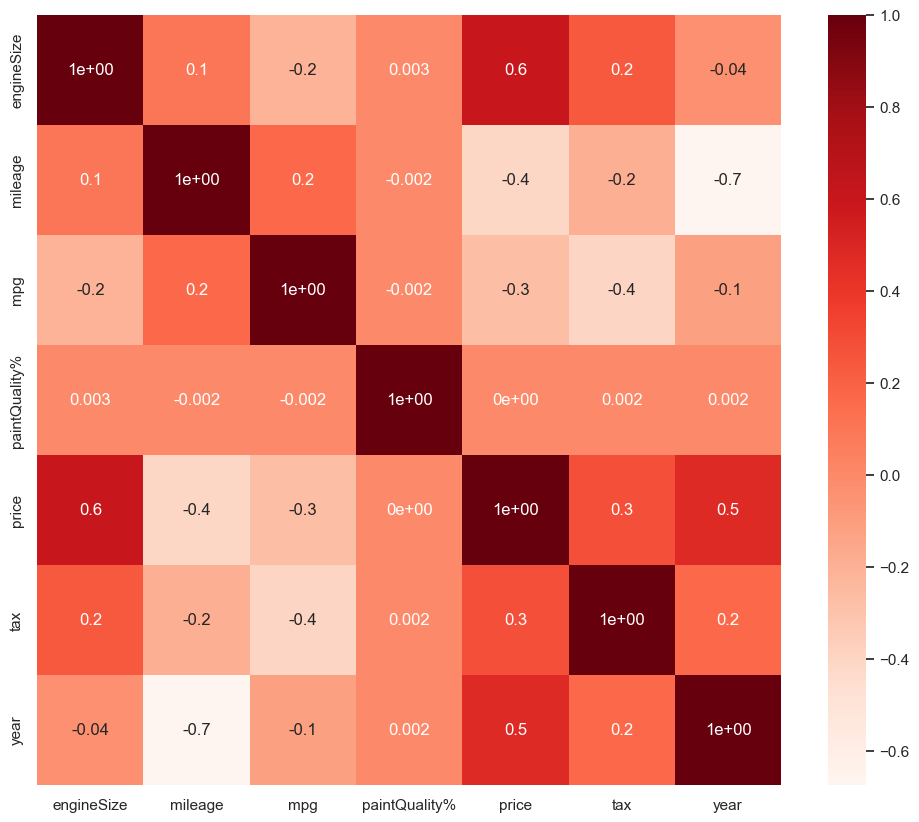

In [57]:
plt.figure(figsize=(12,10))
sns.heatmap(data = pearson_corr, annot = True, cmap = plt.cm.Reds, fmt='.1')
plt.show()

In [58]:
spearman_corr = round(df[col_n].corr(method="spearman"), 3)
spearman_corr

,engineSize,mileage,mpg,paintQuality%,price,tax,year
engineSize,1.000,0.099,-0.179,0.002,0.558,0.143,-0.038
mileage,0.099,1.000,0.307,-0.002,-0.513,-0.240,-0.773
mpg,-0.179,0.307,1.000,0.002,-0.366,-0.533,-0.297
paintQuality%,0.002,-0.002,0.002,1.000,0.003,0.000,0.004
price,0.558,-0.513,-0.366,0.003,1.000,0.298,0.589
tax,0.143,-0.240,-0.533,0.000,0.298,1.000,0.298
year,-0.038,-0.773,-0.297,0.004,0.589,0.298,1.000


<Axes: >

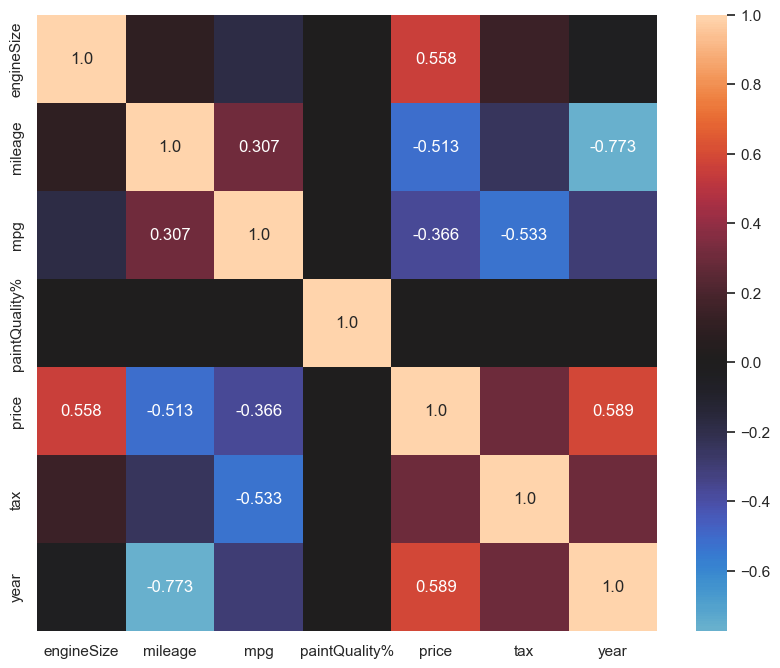

In [59]:


mask_annot = np.absolute(spearman_corr.values) >= 0.3
annot = np.where(mask_annot, spearman_corr.values, np.full(spearman_corr.shape,"")) 

fig = plt.figure(figsize=(10, 8))

sns.heatmap(data=spearman_corr, annot=annot, fmt="", center=0)



In [60]:
train_no_outliers = df_no_outliers[df_no_outliers["train"] == True]

In [61]:
ohe_cols = ["Brand", "transmission", "fuelType"]
freq_col = "model"

# 1. Fit encoders on train dataset
frequency_encoder = ce.CountEncoder(cols=[freq_col], normalize=True)
frequency_encoder.fit(train_no_outliers[[freq_col]])

one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False)
one_hot_encoder.fit(train_no_outliers[ohe_cols])

# 2. Transform dataset (can be train or test)
df_freq = frequency_encoder.transform(df_no_outliers[[freq_col]])
df_freq.columns = ["model_freq"]

df_ohe = one_hot_encoder.transform(df_no_outliers[ohe_cols])
ohe_names = one_hot_encoder.get_feature_names_out(ohe_cols)
df_ohe = pd.DataFrame(df_ohe, columns=ohe_names, index=df_no_outliers.index)

# 3. Combine
df_encoded = pd.concat([df_no_outliers.drop(columns=[freq_col] + ohe_cols), df_freq, df_ohe], axis=1)

df_encoded[df_encoded["train"] == False]
 

,year,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,train,model_freq,...,Brand_Toyota,Brand_Volkswagen,transmission_Manual,transmission_Other,transmission_Semi-Automatic,transmission_Unkown,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
carID,,,,,,,,,,,,,,,,,,,,,
89856,2022,NaN,30700.0,205.0,41.5,1.6,61.0,3.0,False,0.004940,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
106581,2017,NaN,17417.5,150.0,38.2,2.0,60.0,2.0,False,0.016600,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
80886,2016,NaN,36792.0,125.0,51.4,1.5,94.0,2.0,False,0.011379,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
100174,2019,NaN,5533.0,145.0,44.1,1.2,77.0,1.0,False,0.005168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
81376,2019,NaN,9058.0,150.0,51.4,2.0,45.0,4.0,False,0.017845,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105775,2017,NaN,27575.0,145.0,46.3,1.4,94.0,1.0,False,0.016600,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
81363,2020,NaN,1980.0,145.0,34.0,2.0,39.0,3.0,False,0.002490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
76833,2019,NaN,8297.0,145.0,38.2,2.0,88.0,4.0,False,0.007872,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [62]:
df_encoded

,year,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,train,model_freq,...,Brand_Toyota,Brand_Volkswagen,transmission_Manual,transmission_Other,transmission_Semi-Automatic,transmission_Unkown,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
carID,,,,,,,,,,,,,,,,,,,,,
69512,2016,22290.0,28421.0,145.0,11.417268,2.0,63.0,4.0,True,0.043951,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
53000,2019,13790.0,4589.0,145.0,47.900000,1.5,50.0,1.0,True,0.019050,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6366,2019,24990.0,3624.0,145.0,40.900000,1.5,56.0,4.0,True,0.007109,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
29021,2018,12500.0,9102.0,145.0,65.700000,1.0,50.0,2.0,True,0.059601,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10062,2019,22995.0,1000.0,145.0,42.800000,1.5,97.0,3.0,True,0.011379,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105775,2017,NaN,27575.0,145.0,46.300000,1.4,94.0,1.0,False,0.016600,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
81363,2020,NaN,1980.0,145.0,34.000000,2.0,39.0,3.0,False,0.002490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
76833,2019,NaN,8297.0,145.0,38.200000,2.0,88.0,4.0,False,0.007872,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [63]:
df_encoded.head()

,year,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,train,model_freq,...,Brand_Toyota,Brand_Volkswagen,transmission_Manual,transmission_Other,transmission_Semi-Automatic,transmission_Unkown,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
carID,,,,,,,,,,,,,,,,,,,,,
69512,2016,22290.0,28421.0,145.0,11.417268,2.0,63.0,4.0,True,0.043951,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
53000,2019,13790.0,4589.0,145.0,47.900000,1.5,50.0,1.0,True,0.019050,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6366,2019,24990.0,3624.0,145.0,40.900000,1.5,56.0,4.0,True,0.007109,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
29021,2018,12500.0,9102.0,145.0,65.700000,1.0,50.0,2.0,True,0.059601,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10062,2019,22995.0,1000.0,145.0,42.800000,1.5,97.0,3.0,True,0.011379,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [64]:
df_encoded.reset_index(inplace=True)

In [65]:
train_df = df_encoded[df_encoded["train"]]
test_df = df_encoded[~df_encoded["train"]]

In [66]:
test_df

,carID,year,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,train,...,Brand_Toyota,Brand_Volkswagen,transmission_Manual,transmission_Other,transmission_Semi-Automatic,transmission_Unkown,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
74697,89856,2022,NaN,30700.0,205.0,41.5,1.6,61.0,3.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
74698,106581,2017,NaN,17417.5,150.0,38.2,2.0,60.0,2.0,False,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
74699,80886,2016,NaN,36792.0,125.0,51.4,1.5,94.0,2.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
74700,100174,2019,NaN,5533.0,145.0,44.1,1.2,77.0,1.0,False,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
74701,81376,2019,NaN,9058.0,150.0,51.4,2.0,45.0,4.0,False,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107254,105775,2017,NaN,27575.0,145.0,46.3,1.4,94.0,1.0,False,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
107255,81363,2020,NaN,1980.0,145.0,34.0,2.0,39.0,3.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
107256,76833,2019,NaN,8297.0,145.0,38.2,2.0,88.0,4.0,False,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
107257,91768,2019,NaN,17417.5,145.0,28.5,1.3,81.0,1.0,False,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [67]:
train_df.columns

Index(['carID', 'year', 'price', 'mileage', 'tax', 'mpg', 'engineSize',
       'paintQuality%', 'previousOwners', 'train', 'model_freq', 'Brand_BMW',
       'Brand_Ford', 'Brand_Hyundai', 'Brand_Mercedes', 'Brand_Opel',
       'Brand_Skoda', 'Brand_Toyota', 'Brand_Volkswagen',
       'transmission_Manual', 'transmission_Other',
       'transmission_Semi-Automatic', 'transmission_Unkown',
       'fuelType_Electric', 'fuelType_Hybrid', 'fuelType_Other',
       'fuelType_Petrol'],
      dtype='object')

In [68]:
train_df.drop(columns=['train'], inplace=True, errors='ignore')

C:\Users\henri\AppData\Local\Temp\ipykernel_8120\4231951031.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=['train'], inplace=True, errors='ignore')


In [69]:
train_df.columns

Index(['carID', 'year', 'price', 'mileage', 'tax', 'mpg', 'engineSize',
       'paintQuality%', 'previousOwners', 'model_freq', 'Brand_BMW',
       'Brand_Ford', 'Brand_Hyundai', 'Brand_Mercedes', 'Brand_Opel',
       'Brand_Skoda', 'Brand_Toyota', 'Brand_Volkswagen',
       'transmission_Manual', 'transmission_Other',
       'transmission_Semi-Automatic', 'transmission_Unkown',
       'fuelType_Electric', 'fuelType_Hybrid', 'fuelType_Other',
       'fuelType_Petrol'],
      dtype='object')

In [70]:
test_df.drop(columns=["train", "price"], inplace=True, errors='ignore')

C:\Users\henri\AppData\Local\Temp\ipykernel_8120\1852561634.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=["train", "price"], inplace=True, errors='ignore')


In [71]:
feature_cols = [col for col in train_df.columns if col not in ["price", "carID"]]

X_train = train_df[feature_cols]
y_train = train_df["price"]

X_test = test_df[feature_cols]

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

#fit and transform the training and only transform the test data
train_car_enc_scaled = scaler.fit_transform(X_train)
test_car_enc_scaled = scaler.transform(X_test)

X_train_enc_scaled = pd.DataFrame(train_car_enc_scaled, columns=X_train.columns, index=X_train.index) 
X_test_enc_scaled = pd.DataFrame(test_car_enc_scaled, columns=X_test.columns, index=X_test.index) 

In [73]:
X_train_enc_scaled.columns

Index(['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%',
       'previousOwners', 'model_freq', 'Brand_BMW', 'Brand_Ford',
       'Brand_Hyundai', 'Brand_Mercedes', 'Brand_Opel', 'Brand_Skoda',
       'Brand_Toyota', 'Brand_Volkswagen', 'transmission_Manual',
       'transmission_Other', 'transmission_Semi-Automatic',
       'transmission_Unkown', 'fuelType_Electric', 'fuelType_Hybrid',
       'fuelType_Other', 'fuelType_Petrol'],
      dtype='object')

In [74]:
X_test_enc_scaled.columns

Index(['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%',
       'previousOwners', 'model_freq', 'Brand_BMW', 'Brand_Ford',
       'Brand_Hyundai', 'Brand_Mercedes', 'Brand_Opel', 'Brand_Skoda',
       'Brand_Toyota', 'Brand_Volkswagen', 'transmission_Manual',
       'transmission_Other', 'transmission_Semi-Automatic',
       'transmission_Unkown', 'fuelType_Electric', 'fuelType_Hybrid',
       'fuelType_Other', 'fuelType_Petrol'],
      dtype='object')

In [75]:
X_train_enc_scaled.head()

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,model_freq,Brand_BMW,Brand_Ford,...,Brand_Toyota,Brand_Volkswagen,transmission_Manual,transmission_Other,transmission_Semi-Automatic,transmission_Unkown,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,-0.333333,0.456823,0.0,-3.243692,0.500,-0.045475,1.0,0.706956,0.0,0.0,...,0.0,1.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.666667,-0.532590,0.0,-0.541267,-0.125,-0.416903,-0.5,0.000000,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.666667,-0.572653,0.0,-1.059786,-0.125,-0.245475,1.0,-0.339035,0.0,0.0,...,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.333333,-0.345228,0.0,0.777251,-0.750,-0.416903,0.0,1.151273,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.666667,-0.681592,0.0,-0.919045,-0.125,0.925954,0.5,-0.217788,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
X_test_enc_scaled.head()

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,model_freq,Brand_BMW,Brand_Ford,...,Brand_Toyota,Brand_Volkswagen,transmission_Manual,transmission_Other,transmission_Semi-Automatic,transmission_Unkown,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
74697,1.666667,0.551439,3.00,-1.015342,0.000,-0.102617,0.5,-0.400608,0.0,0.0,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74698,0.000000,0.000000,0.25,-1.259786,0.500,-0.131189,0.0,-0.069555,0.0,0.0,...,0.0,1.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
74699,-0.333333,0.804355,-1.00,-0.282008,-0.125,0.840240,0.0,-0.217788,1.0,0.0,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74700,0.666667,-0.493399,0.00,-0.822749,-0.500,0.354525,-0.5,-0.394147,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74701,0.666667,-0.347054,0.25,-0.282008,0.500,-0.559760,1.0,-0.034208,1.0,0.0,...,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0


In [77]:


# Embedded method with Lasso Regression

lasso_reg = LassoCV()

lasso_reg.fit(X_train_enc_scaled, y_train)

coefficient = pd.Series(lasso_reg.coef_, index = X_train_enc_scaled.columns)

print(coefficient.sort_values())
important_features = [coef for coef, val in coefficient.items() if not np.isclose(val, 0.0, atol=1e-6)]
print("Important features:", important_features)

features_to_discard = [coef for coef, val in coefficient.items() if np.isclose(val, 0.0, atol=1e-6)]
print("Features to discard:", features_to_discard)



Brand_Opel                    -6706.724464
Brand_Hyundai                 -5272.340212
Brand_Toyota                  -5204.162898
Brand_Skoda                   -4056.072644
Brand_Ford                    -3337.161265
Brand_Volkswagen              -2673.949301
mileage                       -2396.706418
mpg                           -2149.165520
transmission_Manual           -2068.127345
Brand_BMW                      -901.945240
transmission_Unkown            -779.399750
fuelType_Petrol                -661.030313
tax                             -79.926451
model_freq                      -74.493837
paintQuality%                   -39.420229
fuelType_Other                    0.000000
previousOwners                    0.000000
fuelType_Electric                -0.000000
transmission_Other                0.000000
Brand_Mercedes                  529.697889
transmission_Semi-Automatic     538.333169
year                           3775.767975
fuelType_Hybrid                4310.112168
engineSize 

# Model Fitting

In [80]:
# Linear regression models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.model_selection import KFold, cross_val_score, train_test_split
#Evaluation metrics
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

In [81]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_enc_scaled, y_train,
    test_size=0.20,
    random_state=42,   # reproducible split
    shuffle=True
)

In [82]:
def evaluation_report(y_true, y_pred):
    r2   = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    print(f"R²: {r2:.4f} | MAE: {mae:,.2f} | RMSE: {rmse:,.2f}")

In [83]:
## Regressão Linear

In [84]:

ols = LinearRegression()

# fit on the train data
ols.fit(X_train, y_train)

# Predictions
y_pred_train_ols = ols.predict(X_train)
y_pred_val_ols = ols.predict(X_val)

print("TRAIN performance using OLS:")
evaluation_report(y_train, y_pred_train_ols)

print("\nVALIDATION performance using OLS:")
evaluation_report(y_val, y_pred_val_ols)

TRAIN performance using OLS:
R²: 0.7697 | MAE: 2,986.30 | RMSE: 4,441.57

VALIDATION performance using OLS:
R²: 0.7686 | MAE: 2,997.78 | RMSE: 4,497.00


In [85]:
## Random Forests

In [86]:


random_forest_regressor = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=1)
# We can do hyperparameter tunning to get a better performance from the model

# fit the model to the training data
random_forest_regressor.fit(X_train, y_train)

# Predict on the training and validation data 
y_pred_train_rfr = random_forest_regressor.predict(X_train)
y_pred_val_rfr = random_forest_regressor.predict(X_val)

print("TRAIN performance using Random Forest Regressor:")
evaluation_report(y_train, y_pred_train_rfr)

print("\nVALIDATION performance using Random Forest Regressor:")
evaluation_report(y_val, y_pred_val_rfr)



TRAIN performance using Random Forest Regressor:
R²: 0.9918 | MAE: 512.69 | RMSE: 839.88

VALIDATION performance using Random Forest Regressor:
R²: 0.9441 | MAE: 1,388.06 | RMSE: 2,210.71


In [87]:
## Elastiic Net

In [89]:


elastic_net = ElasticNet()

# we can use hyperparameter tuning to get a better performance out of the model

# fit the model to the training data
elastic_net.fit(X_train, y_train)

# Predict on the training and validation data 
y_pred_train_en = elastic_net.predict(X_train)
y_pred_val_en = elastic_net.predict(X_val)

print("TRAIN performance using ElasticNet:")
evaluation_report(y_train, y_pred_train_en)

print("\nVALIDATION performance using ElasticNet:")
evaluation_report(y_val, y_pred_val_en)



TRAIN performance using ElasticNet:
R²: 0.6339 | MAE: 3,757.40 | RMSE: 5,599.97

VALIDATION performance using ElasticNet:
R²: 0.6317 | MAE: 3,783.33 | RMSE: 5,672.66
